# Video Stabilization Using Point Feature Matching in OpenCV
It refers to a family of methods used to reduce the effect of camera motion on the final video. The motion of the camera would be a translation ( i.e. movement in the x, y, z-direction ) or rotation (yaw, pitch, roll).

## Different Approaches to Video Stabilization
Video Stabilization approaches include mechanical, optical and digital stabilization methods. These are discussed briefly below:

1. Mechanical Video Stabilization: Mechanical image stabilization systems use the motion detected by special sensors like gyros and accelerometers to move the image sensor to compensate for the motion of the camera.

2. Optical Video Stabilization: In this method, instead of moving the entire camera, stabilization is achieved by moving parts of the lens. This method employs a moveable lens assembly that variably adjusts the path length of light as it travels through the camera’s lens system.

3. Digital Video Stabilization:  This method does not require special sensors for estimating camera motion. There are three main steps — i. motion estimation ii. motion smoothing, and iii. image composition. The transformation parameters between two consecutive frames are derived in the first stage. The second stage filters out unwanted motion and in the last stage the stabilized video is reconstructed.

We will learn a fast and robust implementation of a digital video stabilization algorithm in this post. It is based on a two-dimensional motion model where we apply a Euclidean (a.k.a Similarity) transformation incorporating translation, rotation, and scaling.

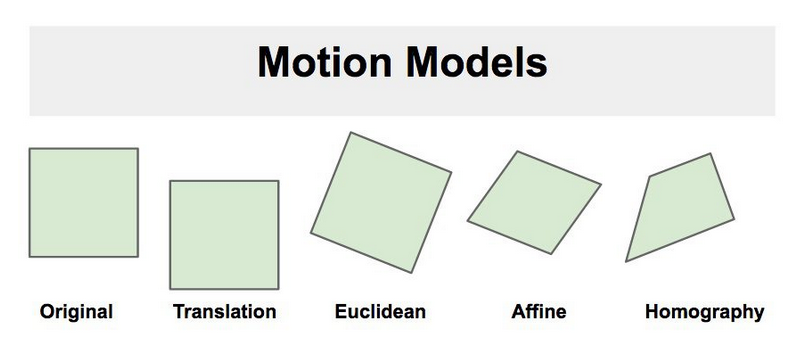

As you can see in the image above, in a Euclidean motion model, a square in an image can transform to any other square with a different location, size or rotation. It is more restrictive than affine and homography transforms but is adequate for motion stabilization because the camera movement between successive frames of a video is usually small.



## Video Stabilization Using Point Feature Matching
This method involves tracking a few feature points between two consecutive frames. The tracked features allow us to estimate the motion between frames and compensate for it.

The flowchart below shows the basic steps.

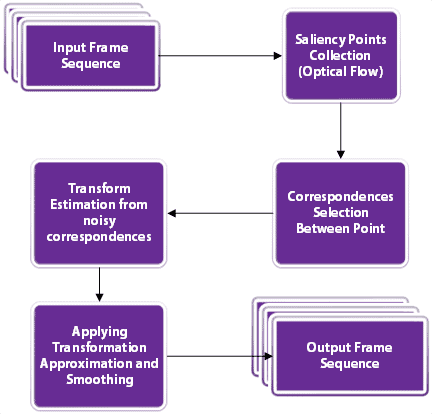

Let’s go over the steps.
### Step 1 : Set Input and Output Videos
First, let’s complete the setup for reading the input video and writing the output video.

### Step 2: Read the first frame and convert it to grayscale
For video stabilization, we need to capture two frames of a video, estimate motion between the frames, and finally correct the motion.

### Step 3: Find motion between frames
This is the most crucial part of the algorithm. We will iterate over all the frames, and find the motion between the current frame and the previous frame. It is not necessary to know the motion of each and every pixel. The Euclidean motion model requires that we know the motion of only 2 points in the two frames. However, in practice, it is a good idea to find the motion of 50-100 points, and then use them to robustly estimate the motion model.

#### 3.1 Good Features to Track
The question now is what points should we choose for tracking. Keep in mind that tracking algorithms use a small patch around a point to track it. Such tracking algorithms suffer from the aperture problem as explained in the video below.
So, smooth regions are bad for tracking and textured regions with lots of corners are good. Fortunately, OpenCV has a fast feature detector that detects features that are ideal for tracking. It is called goodFeaturesToTrack.

#### 3.2 Lucas-Kanade Optical Flow

Once we have found good features in the previous frame, we can track them in the next frame using an algorithm called Lucas-Kanade Optical Flow named after the inventors of the algorithm.

It is implemented using the function calcOpticalFlowPyrLK in OpenCV. In the name calcOpticalFlowPyrLK, LK stands for Lucas-Kanade, and Pyr stands for the pyramid. An image pyramid in computer vision is used to process an image at different scales (resolutions).

calcOpticalFlowPyrLK may not be able to calculate the motion of all the points because of a variety of reasons. For example, the feature point in the current frame could get occluded by another object in the next frame. Fortunately, as you will see in the code below, the status flag in calcOpticalFlowPyrLK can be used to filter out these values.

#### 3.3 Estimate Motion
To recap, in step 3.1, we found good features to track in the previous frame. In step 3.2, we used optical flow to track the features. In other words, we found the location of the features in the current frame, and we already knew the location of the features in the previous frame. So we can use these two sets of points to find the rigid (Euclidean) transformation that maps the previous frame to the current frame. This is done using the function estimateRigidTransform.

Once we have estimated the motion, we can decompose it into x and y translation and rotation (angle). We store these values in an array so we can change them smoothly.

The code below goes over steps 3.1 to 3.3. Make sure to read the comments in the code to follow along.

### Step 4: Calculate smooth motion between frames
In the previous step, we estimated the motion between the frames and stored them in an array. We now need to find the trajectory of motion by cumulatively adding the differential motion estimated in the previous step.

#### Step 4.1 : Calculate trajectory
In this step, we will add up the motion between the frames to calculate the trajectory. Our ultimate goal is to smooth out this trajectory.


#### Step 4.2 : Calculate smooth trajectory
In the previous step, we calculated the trajectory of motion. So we have three curves that show how the motion (x, y, and angle) changes over time.

In this step, we will show how to smooth these three curves.

The easiest way to smooth any curve is to use a moving average filter. As the name suggests, a moving average filter replaces the value of a function at the point by the average of its neighbors defined by a window. Let’s look at an example.

Let’s say we have stored a curve in an array $c$, so the points on the curve are c[0] … c[n-1]. Let f be the smooth curve we obtain by filtering c with a moving average filter of width 5.

The $k^{th}$ element of this curve is calculated using

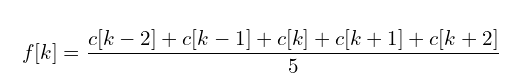

As you can see, the values of the smooth curve are the values of the noisy curve averaged over a small window. The figure below shows an example of the noisy curve on the left, smoothed using a box filter of size 5 on the right.

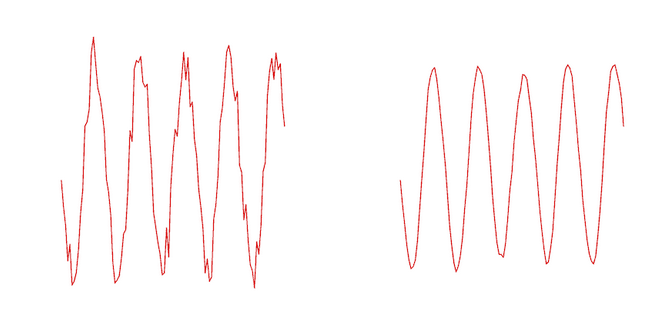

In the Python implementation, we define a moving average filter that takes in any curve ( i.e. a 1-D of numbers) as an input and returns the smoothed version of the curve.

We also define a function that takes in the trajectory and performs smoothing on the three components.

#### Step 4.3 : Calculate smooth transforms
So far we have obtained a smooth trajectory. In this step, we will use the smooth trajectory to obtain smooth transforms that can be applied to frames of the videos to stabilize it.

This is done by finding the difference between the smooth trajectory and the original trajectory and adding this difference back to the original transforms.

#### Step 5: Apply smoothed camera motion to frames
We are almost done. All we need to do now is to loop over the frames and apply the transforms we just calculated.

If we have a motion specified as $(x, y, \theta)$, the corresponding transformation matrix is given by
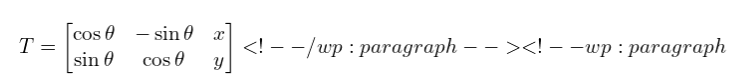


#### Step 5.1 : Fix border artifacts
When we stabilize a video, we may see some black boundary artifacts. This is expected because to stabilize the video, a frame may have to shrink in size.

We can mitigate the problem by scaling the video about its center by a small amount (e.g. 4%).

The function fixBorder below shows the implementation. We use getRotationMatrix2D because it scales and rotates the image without moving the center of the image. All we need to do is call this function with 0 rotation and scale 1.04 ( i.e. 4% upscale).

## Code Implementation

In [1]:
# Import numpy and OpenCV
import numpy as np
import cv2


In [2]:
def movingAverage(curve, radius): 
    window_size = 2 * radius + 1
    # Define the filter 
    f = np.ones(window_size)/window_size 
    # Add padding to the boundaries 
    curve_pad = np.lib.pad(curve, (radius, radius), 'edge') 
    # Apply convolution 
    curve_smoothed = np.convolve(curve_pad, f, mode='same') 
    # Remove padding 
    curve_smoothed = curve_smoothed[radius:-radius]
    # return smoothed curve
    return curve_smoothed 

In [3]:
def smooth(trajectory, smoothing_radius): 
    smoothed_trajectory = np.copy(trajectory) 
    # Filter the x, y and angle curves
    for i in range(3):
        smoothed_trajectory[:,i] = movingAverage(trajectory[:,i], radius=smoothing_radius)

    return smoothed_trajectory

In [4]:
def fixBorder(frame):
    s = frame.shape
    # Scale the image 4% without moving the center
    T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.04)
    frame = cv2.warpAffine(frame, T, (s[1], s[0]))
    return frame

In [5]:
# The larger the more stable the video, but less reactive to sudden panning
SMOOTHING_RADIUS=50 

# Read input video
cap = cv2.VideoCapture('./videos/Man Walking Through the City - 4k Ultra HD Stock Footage.mp4') 
 
# Get frame count
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 
 
# Get width and height of video stream
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Get frames per second (fps)
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # MP4 codec

out = cv2.VideoWriter('video_out.mp4', fourcc, fps, (2 * w, h))

# Read first frame
_, prev = cap.read() 
 
# Convert frame to grayscale
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY) 

# Pre-define transformation-store array
transforms = np.zeros((n_frames-1, 3), np.float32) 

for i in range(n_frames-2):
    # Detect feature points in previous frame
    prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                     maxCorners=200,
                                     qualityLevel=0.01,
                                     minDistance=30,
                                     blockSize=3)
   
    # Read next frame
    success, curr = cap.read() 
    if not success: 
        break 
    
    # Convert to grayscale
    curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY) 

    # Calculate optical flow (i.e. track feature points)
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None) 

    # Sanity check
    assert prev_pts.shape == curr_pts.shape 
    
    # Filter only valid points
    idx = np.where(status==1)[0]
    prev_pts = prev_pts[idx]
    curr_pts = curr_pts[idx]

    #Find transformation matrix
    m, _ = cv2.estimateAffinePartial2D(prev_pts, curr_pts)
    
    # Extract translation
    dx = m[0,2]
    dy = m[1,2]

    # Extract rotation angle
    da = np.arctan2(m[1,0], m[0,0])
    
    # Store transformation
    transforms[i] = [dx,dy,da]
   
    # Move to next frame
    prev_gray = curr_gray

    print("Frame: " + str(i) +  "/" + str(n_frames) + " -  Tracked points : " + str(len(prev_pts)))
    
# Compute trajectory using cumulative sum of transformations
trajectory = np.cumsum(transforms, axis=0) 
 
# Create variable to store smoothed trajectory
smoothed_trajectory = smooth(trajectory, smoothing_radius=SMOOTHING_RADIUS) 

# Calculate difference in smoothed_trajectory and trajectory
difference = smoothed_trajectory - trajectory
 
# Calculate newer transformation array
transforms_smooth = transforms + difference

# Reset stream to first frame 
cap.set(cv2.CAP_PROP_POS_FRAMES, 0) 

# Write n_frames-1 transformed frames
for i in range(n_frames-2):
    # Read next frame
    success, frame = cap.read() 
    if not success:
        break

    # Extract transformations from the new transformation array
    dx = transforms_smooth[i,0]
    dy = transforms_smooth[i,1]
    da = transforms_smooth[i,2]

    # Reconstruct transformation matrix accordingly to new values
    m = np.zeros((2,3), np.float32)
    m[0,0] = np.cos(da)
    m[0,1] = -np.sin(da)
    m[1,0] = np.sin(da)
    m[1,1] = np.cos(da)
    m[0,2] = dx
    m[1,2] = dy

    # Apply affine wrapping to the given frame
    frame_stabilized = cv2.warpAffine(frame, m, (w,h))

    # Fix border artifacts
    frame_stabilized = fixBorder(frame_stabilized) 

    # Write the frame to the file
    frame_out = cv2.hconcat([frame, frame_stabilized])

    # If the image is too big, resize it.
    if(frame_out.shape[1] > 1920): 
        frame_out = cv2.resize(frame_out, (frame_out.shape[1]/2, frame_out.shape[0]/2));
  
    cv2.imshow("Before and After", frame_out)
    cv2.waitKey(10)
    out.write(frame_out)
    
# Release video
cap.release()
out.release()
# Close windows
cv2.destroyAllWindows()

Frame: 0/693 -  Tracked points : 73
Frame: 1/693 -  Tracked points : 73
Frame: 2/693 -  Tracked points : 73
Frame: 3/693 -  Tracked points : 78
Frame: 4/693 -  Tracked points : 77
Frame: 5/693 -  Tracked points : 75
Frame: 6/693 -  Tracked points : 65
Frame: 7/693 -  Tracked points : 61
Frame: 8/693 -  Tracked points : 65
Frame: 9/693 -  Tracked points : 66
Frame: 10/693 -  Tracked points : 66
Frame: 11/693 -  Tracked points : 60
Frame: 12/693 -  Tracked points : 66
Frame: 13/693 -  Tracked points : 69
Frame: 14/693 -  Tracked points : 69
Frame: 15/693 -  Tracked points : 72
Frame: 16/693 -  Tracked points : 69
Frame: 17/693 -  Tracked points : 72
Frame: 18/693 -  Tracked points : 70
Frame: 19/693 -  Tracked points : 71
Frame: 20/693 -  Tracked points : 69
Frame: 21/693 -  Tracked points : 67
Frame: 22/693 -  Tracked points : 73
Frame: 23/693 -  Tracked points : 70
Frame: 24/693 -  Tracked points : 70
Frame: 25/693 -  Tracked points : 68
Frame: 26/693 -  Tracked points : 71
Frame: 27/6

QObject::moveToThread: Current thread (0x23139a0) is not the object's thread (0x2df9b30).
Cannot move to target thread (0x23139a0)

QObject::moveToThread: Current thread (0x23139a0) is not the object's thread (0x2df9b30).
Cannot move to target thread (0x23139a0)

QObject::moveToThread: Current thread (0x23139a0) is not the object's thread (0x2df9b30).
Cannot move to target thread (0x23139a0)

QObject::moveToThread: Current thread (0x23139a0) is not the object's thread (0x2df9b30).
Cannot move to target thread (0x23139a0)

QObject::moveToThread: Current thread (0x23139a0) is not the object's thread (0x2df9b30).
Cannot move to target thread (0x23139a0)

QObject::moveToThread: Current thread (0x23139a0) is not the object's thread (0x2df9b30).
Cannot move to target thread (0x23139a0)

QObject::moveToThread: Current thread (0x23139a0) is not the object's thread (0x2df9b30).
Cannot move to target thread (0x23139a0)

QObject::moveToThread: Current thread (0x23139a0) is not the object's thread

Left: Input video. Right: Stabilized video.

The result of the stabilization code we have shared is shown above. Our objective was to reduce the motion significantly, but not to eliminate it completely.

We leave it to the reader to think of a modification of the code that will eliminate motion between frames completely. What could be the side effects if you try to eliminate all camera motion?

The current method only works for a fixed length video and not with a real-time feed.  We have to modify this method heavily to attain real-time video output which is out of the scope for this experiment but it is achievable.

## Pros and Cons

### Pros
- This method provides good stability against low-frequency motion (slower vibrations).
- This method has low memory consumption thereby ideal for Embedded devices(like Raspberry Pi).
- This method is good against zooming(scaling) jitter in the video.

### Cons
- This method performs poorly against high-frequency perturbations.
- If there is a heavy motion blur, feature tracking will fail and the results would not be optimal.
- This method is also not good with Rolling Shutter distortion.